# Спрос на рынке жилья (за счет собственных средств)

In [1]:
from IPython.display import Markdown as md
import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

%run ../COMMON/common.ipynb # загрузка общих функций и констант, все, что оттуда, должно иметь префикс common.

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strYearDBPath)) # connection к рабочей базе данных
conWorkEx = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strExYearDBPath)) # connection к к рабочей базе данных экзогенных переменных
conWorkExH=sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strExParamDBPath)) # connection к рабочей базе данных экзогенных параметров
conWorkSvod=sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strSvodDBPath)) # connection к рабочей базе данных СВОД


## Загрузка исходных данных

Исходные данные:
  - Фактические значения - из базы данных `year.sqlite3`;
  - Экзогенные - из базы данных `exog_year.sqlite3`
  - Задаваемые вручную - из базы данных `exog_param.sqlite3`
  - Результаты других моделей - из базы данных `svod.sqlite3`. *В эту же базу записываем результаты данного блокнота*. А даном блокноте используются результаты блока **"Цены и себестоимость"**

In [11]:
lstYearCodes=['CPIAv', 'Pop_x', 'HHAv', 'Unmpl_s', 'DispInc_rI', 'Inc_x', 'p_ProbDef', 
              'UZUss_x', 'MEPop', 'DispPop', 'LivMin', 'p_superrich'] # список экзогенных и фактических данных
 

lstSvod=['price1mddy_alt_x', 'price1mall_alt_x'] # результаты из блока "Цены и себестоимость"

pdfAct=pd.read_sql(common.make_SELECT_YEAR_string(lstYearCodes), con=conWork).pipe(common.make_frame)
pdfExog=pd.read_sql(common.make_SELECT_YEAR_string(lstYearCodes), con=conWorkEx).pipe(common.make_frame)
PdfExogHandle=pd.read_sql(common.make_SELECT_YEAR_string(lstYearCodes), con=conWorkExH).pipe(common.make_frame)
pdfSvod=pd.read_sql(common.make_SELECT_YEAR_string(lstSvod), con=conWorkSvod).pipe(common.make_frame)

pdfWork=pd.concat([pdfAct, pdfExog[~pdfExog.index.isin(pdfAct.index)]]).combine_first(PdfExogHandle).join(pdfSvod)

pdfWork

,CPIAv,DispPop,HHAv,Inc_x,LivMin,MEPop,Pop_x,UZUss_x,Unmpl_s,p_ProbDef,p_superrich,price1mall_alt_x,price1mddy_alt_x
date,,,,,,,,,,,,,
2004,1.108812,NaN,2.677054,6.410300,2376.0,NaN,144.067300,NaN,0.077149,NaN,NaN,NaN,NaN
2005,1.127055,0.756100,2.661470,8.088300,3018.0,8.711611,143.518814,NaN,0.071532,NaN,0.02,21.048567,18.491693
2006,1.096830,0.769907,2.645886,10.154800,3422.0,8.928732,143.049637,NaN,0.070622,NaN,0.02,28.597165,24.937897
2007,1.089881,0.785663,2.630302,12.540200,3847.0,9.129498,142.805114,NaN,0.060294,0.10,0.02,37.938493,32.765903
2008,1.141048,0.782878,2.614717,14.863600,4593.0,9.301331,142.742366,9.763312,0.062412,0.10,0.02,44.576706,37.788916
2009,1.116977,0.783533,2.599133,16.895000,5153.0,9.427587,142.785348,10.421675,0.082522,0.10,0.02,42.565501,36.473861
2010,1.068508,0.782280,2.583549,18.958400,5688.0,9.546797,142.849468,11.124432,0.073445,0.10,0.02,41.870585,35.853806
2011,1.084634,0.775441,2.544156,20.780000,6369.0,9.644999,142.960908,11.874579,0.064956,0.10,0.02,44.815618,37.897473
2012,1.050667,0.781314,2.504763,23.221100,6510.0,9.747765,143.201721,12.675309,0.054587,0.10,0.02,50.629951,41.865338


## Дополнительные расчеты

### 1. Потенциальный спрос на жилье (без лага с весом 0.5, с лагом 1 год с весом 0.5) - _PDHouses_w (параметр модели Спроса)    
<br>   
   
   
<center>$\_PDHouses\_w = \ln(\dfrac{\_Calc\_PD\_FH\_OM\_Corr_{y-1} * 0.5 + \_Calc\_PD\_FH\_OM\_Corr_y * 0.5}{(1+p\_ProbDef) * \dfrac{price1mddy\_alt\_x}{price1mall\_alt\_x}}  )$</center>


где:   

  - `_Calc_PD_FH_OM_Corr` - Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий (**расчет**)
  - `_ProbDef` - Вероятность дефолта проекта и/или застройщика
  - `price1mddy_alt_x` - Средняя цена 1 кв. м по ДДУ
  - `price1mall_alt_x` - Средняя цена 1 кв. м на рынке готового жилья
  
#### Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий - _Calc_PD_FH_OM_Corr    
<br>

<center>$\_Calc\_PD\_FH\_OM\_Corr = \dfrac{\_PD+p\_superrich * \_superrich\_buy * Pop\_x}{1000}\quad *\quad (1-\_p\_self\_improve_{y-1})$</center>

где:
  - <b>_PD</b> - Потенциальный спрос: $\_PD = \dfrac{\_val\_incom2house * 1000}{price1mddy\_alt\_x}$</center>
    - <b>price1mddy_alt_x</b> - Средняя цена 1 кв. м по ДДУ (**загружаем - СВОД**)
    - <b>_val_incom2house</b> - Общий объем денежных доходов, которые могут потратить на жилье: $\_val\_incom2house = \_val\_m4h - \_sum\_val\_PM4dem\_h\_om$
      - <b>_val_m4h</b> - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ): $\_val\_m4h = \_comm\_income * \_p\_income4h$ 
        - <b>_comm_income</b> - Общий объем денежных доходов населения: $ \_comm\_income = (Inc\_x * 12) * \dfrac{Pop\_x}{1000000} $>
          - <b>Inc_x</b> - Среднедушевые денежные доходы населения (в текущих ценах) (**загружаем**)
          - <b>Pop_x</b> - Численность населения (среднегодовая) (**загружаем**)
        - <b>_p_income4h</b> - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения: $ \_p\_income4h =  \_part\_income4h - \_p\_income\_superr$   
          - <b>_part_income4h</b> - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) (**расчет**)
          - <b>_p_income_superr</b> - Доля доходов сверхбогатого населения  (**расчет**)
<hr>          
      - **_sum_val_PM4dem_h_om** - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств (**расчет**)
      
  - `p_superrich` - Доля сверхбогатого населения (**загружаем**)
  - `_superrich_buy` - Типовая покупка жилья сверхбогатым населением в год на чел (**расчет**)
  - `Pop_x` -  Численность населения (среднегодовая) (**загружаем**)
  - `_p_self_improve` - Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % (**расчет**)
  
 
<hr>

#### Типовая покупка жилья сверхбогатым населением в год на чел
$ \begin{equation*}
\_superrich\_buy =  
 \begin{cases}
   \dfrac{34.71428571}{HHAv}; \quad \text{при} \quad 2008<= y <= 2024\\
   \_superrich\_buy_{2024} + \dfrac{\_superrich\_buy_{2030} - \_superrich\_buy_{2024}}{6};  \quad \text{при} \quad y=2025\\
   2 * \_superrich\_buy_{y-1} - \_superrich\_buy_{y-2};  \quad \text{при} \quad 2025<y<2030\\
   0; \quad \text{при} \quad y=2030
 \end{cases}
\end{equation*} $  


#### Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % - _p_self_improve

$\_p\_self\_improve = \dfrac{UZUss\_s}{\_cnt\_hh}$

где:
  - `UZUss_x` - Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет
  - `_cnt_hh` - Число домохозяйств
  
  
  
$LivMin\_f_y = LivMin_{y-1}*CPIAv$    

где:
  - CPIAv - ИПЦ, в среднем за год
  - LivMin_f - Прожиточный минимумпрогнозные значения

In [25]:
pdfAct

,CPIAv,HHAv,Inc_x,Pop_x,Unmpl_s
date,,,,,
2004,1.108812,2.677054,6.4103,144.067300,0.077149
2005,1.127055,2.661470,8.0883,143.518814,0.071532
2006,1.096830,2.645886,10.1548,143.049637,0.070622
2007,1.089881,2.630302,12.5402,142.805114,0.060294
2008,1.141048,2.614717,14.8636,142.742366,0.062412
2009,1.116977,2.599133,16.8950,142.785348,0.082522
2010,1.068508,2.583549,18.9584,142.849468,0.073445
2011,1.084634,2.544156,20.7800,142.960908,0.064956
2012,1.050667,2.504763,23.2211,143.201721,0.054587


In [422]:
from scipy.integrate import quad
from scipy.stats import rv_continuous

income_mean=20780

m0=9.64
s0=0.78
m2=np.exp(m0)
s2=np.exp(s0)

def lnorm(x, s=0.78, loc=0, scale=1):
    y =  (x-loc)/scale 
    
    d1 = -1 * (np.log(y) - loc) ** 2
    d2 = 2 * (s ** 2)
    d3 = d1 / d2
    d4 = np.exp(d3)
    
    d0 = 1 / (s * np.sqrt(2 * np.longdouble(np.pi)))
    
    return (d0 * d4)

def lnorm_(x, s=0.78, loc=0, scale=1):
    y =  (x-loc)/scale 
    
    d1 = -1 * (np.log(y) - loc) ** 2
    d2 = 2 * (s ** 2)
    d3 = d1 / d2
    d4 = np.exp(d3)
    
    d0 = 1 / x*(s * np.sqrt(2 * np.longdouble(np.pi)))
    
    return (d0 * d4)


def norm2(x, s, loc=0, scale=1):
    return lognorm.pdf(x, s, loc=loc, scale=scale) *  x

class kolmakov_distr(lognorm):
#     def _pdf(self, x):
#         return (1/self.s*np.sqrt(2*np.pi))*np.e ** ((-np.log(x)**2) / 2*self.s**2)
    def _pdf(self, x, s):
        return super._pdf(x, s)
        
# kolmakov=kolmakov_distr(name='lognorm')

In [ ]:
class kolmakov_gen(rv_continuous):
    """A lognormal continuous random variable.

    %(before_notes)s

    Notes
    -----
    The probability density function for `lognorm` is::

        lognorm.pdf(x, s) = 1 / (s*x*sqrt(2*pi)) * exp(-1/2*(log(x)/s)**2)

    for ``x > 0``, ``s > 0``.

    If log x is normally distributed with mean mu and variance sigma**2,
    then x is log-normally distributed with shape paramter sigma and scale
    parameter exp(mu).

    %(example)s

    """
    def pdf(self, x, *argc, **argv):
        print(argv)
        super.pdf(x, , *argc, **argv)
        
    def _rvs(self, s):
        return np.exp(s * norm.rvs(size=self._size))
    def _pdf(self, x, s, *args):
        print(self.param)
        Px = np.exp(-np.log(x)**2 / (2*s**2))
        return Px / (s*np.sqrt(2*np.pi))
    def _cdf(self, x, s):
        return norm.cdf(np.log(x)/s)
    def _ppf(self, q, s):
        return np.exp(s*norm._ppf(q))
    def _stats(self, s):
        p = np.exp(s*s)
        mu = np.sqrt(p)
        mu2 = p*(p-1)
        g1 = np.sqrt((p-1))*(2+p)
        g2 = numpy.polyval([1,2,3,0,-6.0],p)
        return mu, mu2, g1, g2
    def _entropy(self, s):
        return 0.5*(1+np.log(2*np.pi)+2*np.log(s))
kolmakov = kolmakov_gen(a=0.0, name='lognorm', shapes='s')

In [ ]:
kd=kolmakov(s0, scale=m2, loc=0)

print(lnorm(75929, s0, loc=m0))
print(norm2(75929, s0, scale=m2))
print(kolmakov.pdf(75929, s0, scale=m2)*m2)

In [399]:
print(1-quad(lnorm, 0, 75929, args=(s0, 0, np.exp(m0)))[0]/income_mean)
print(1-quad(lnorm_, 0, 75929, args=(s0, 0, np.exp(m0)))[0]/income_mean*np.log(75929))
print(1-quad(norm2, 0, 75929, args=(s0, 0, m2))[0]/income_mean)

0.10016764356590346
0.9979746482110731
0.10016764356590346


In [389]:
print(1-lognorm.cdf(75929, s=s0, scale=m2)/np.log(75929))
print(lognorm.sf(75929, s=s0, scale=m2))

0.9128166894383722
0.0202728420977415


In [348]:
lognorm(s=s0, scale=income_mean).ppf(0.98)

103122.2457030286

In [350]:
print(1-quad(norm2, 0, lognorm(s=s0, scale=income_mean).ppf(0.98), args=(s0, 0, m2))[0]/income_mean)

0.0460587434073545


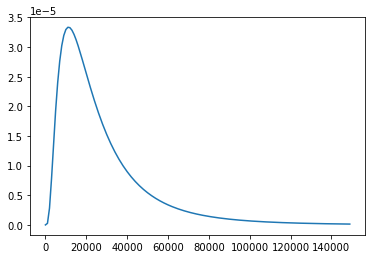

In [372]:
lst=list(range(0, 150000, 1000))
lgn=lognorm(s=s0, scale=income_mean)
lstl=[lgn.pdf(x) for x in lst]
plt.plot(lst, lstl)

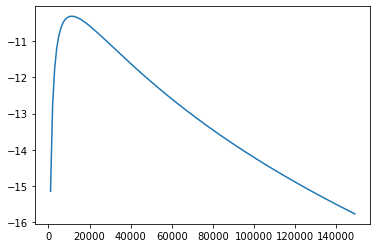

In [374]:
plt.plot(lst, np.log(lstl))

In [385]:
from scipy.stats import norm

nrm=norm(loc=m0, scale=s0)
np.exp(nrm.ppf(0.98))

76261.54938110473